In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/CMAP data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
directions_bicycling.json  directions_walking.json  location.csv  X0.csv
directions_driving.json    gps_place.csv	    person.csv	  X.csv
directions_transit.json    household.csv	    place.csv	  y.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, norm, matmul, transpose, randn
from torch.nn.functional import softmax
from torch.autograd import grad, Variable
from torch.autograd.functional import jacobian
from torch.utils.data import Dataset, DataLoader

# Data import and processing

In [ ]:
X0 = pd.read_csv('/content/drive/My Drive/CMAP data/X0.csv', index_col=0)
y0 = pd.read_csv('/content/drive/My Drive/CMAP data/y.csv', index_col=0)['mode_imputed']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=.1, random_state=1)

In [ ]:
X0.describe()

,age,hhveh,hhinc,dist_auto,time_auto,dist_walk,time_walk,dist_train,time_train,dist_bike,time_bike,cost_transit,cost_driving
count,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000,34128.000000
mean,39.785572,1.582366,7.549168,9.158925,16.278894,7.522189,150.532221,10.341716,62.416233,9.130393,49.190776,2.435255,0.417927
std,13.425956,1.021446,2.491486,30.517891,27.504826,27.020464,531.056967,30.168473,72.050618,32.067124,160.322656,0.864776,2.140678
min,6.000000,0.000000,1.000000,0.139838,0.550000,0.139838,3.183333,0.139838,3.183333,0.139838,1.116667,0.250000,0.000000
25%,30.000000,1.000000,6.000000,2.277294,8.230556,1.946861,39.537500,2.162316,27.000000,2.176041,13.000000,1.833333,0.000000
50%,38.000000,2.000000,8.000000,4.411436,11.855556,3.912989,78.883333,4.924073,41.605556,4.227574,24.058333,2.208333,0.000000
75%,49.000000,2.000000,9.000000,8.745183,18.069444,7.682204,154.802778,11.009840,69.400000,8.549927,47.033333,2.541667,0.000000
max,84.000000,8.000000,10.000000,1371.606588,1202.900000,1267.801740,24929.533333,1481.846489,2183.150000,1422.297700,7096.366667,10.000000,100.975000


## Test data for predictions

In [ ]:
X_prob = pd.DataFrame(np.zeros((100, 13)), columns=X0.columns)
X_prob['cost_transit'] = np.linspace(0, 10, 100)

y_prob = pd.Series(np.ones(101))

# Deep neural network

In [ ]:
class Load_Data(Dataset):
    def __init__(self, x_set, y_set):
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

# Load data
train_data = Load_Data(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = Load_Data(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32)

prob_data = Load_Data(X_prob, y_prob)
prob_loader = DataLoader(prob_data)

In [ ]:
class FeedForward_DNN(nn.Module):
    def __init__(self):
        super(FeedForward_DNN, self).__init__()
        # 3 hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )
    
    def forward(self, x):
        return self.linear_relu_stack(x)

def s_jac(x):
    return nn.functional.softmax(model(x), dim=0)

def v_jac(x):
    return model(x)

def cal_loss(X, pred, y, reg, gamma):
    loss = criterion(pred, y)
    # L1 penalty of parameters
    if reg == 'L1':
        R = sum(p.abs().sum() for p in model.parameters())
    # L2 penalty of parameters
    elif reg == 'L2':
        R = sum(p.pow(2).sum() for p in model.parameters()).pow(.5)
    # Double backpropagation
    elif reg == 'DblBack':
        R = sum(g.pow(2).sum() for g in grad(loss, X, retain_graph=True))
    # Jacobian regularizer
    elif reg == 'JacReg':
        R = sum([norm(jacobian(s_jac, x, create_graph=True)).pow(2) for x in X])
    # Frobenius regularizer
    elif reg == 'FrobReg':
        R = sum([norm(jacobian(v_jac, x, create_graph=True)).pow(2) for x in X])
    # Spectral Regularizer
    elif reg == 'SpecReg':
        R = 0
        for x in X:
            P_jac = matmul(transpose(jacobian(v_jac, x, create_graph=True), 0, 1), randn(4))
            R += P_jac.pow(2).sum()
    else:
        R = 0
    loss += gamma * R
    return loss

def train_loop(dataloader, reg, gamma):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = cal_loss(X, pred, y, reg, gamma)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader, reg, gamma):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    for X, y in dataloader:
        pred = model(X)
        test_loss += cal_loss(X, pred, y, reg, gamma).item()
        correct += (pred.argmax(1) == y).float().sum()
    list_prob = [softmax(model(X), dim=1)[:, 2].detach().numpy()[0] for X, _ in prob_loader]
    test_loss /= num_batches
    correct /= size
    print(f'test_accuracy = {100*correct:.2f}%,    avg_test_loss = {test_loss:.4f}')
    return test_loss, list_prob

In [ ]:
# Initialize network
model = FeedForward_DNN()

# Initialize hyperparameters
learning_rate = 1e-3
num_epochs = 10

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_DNN(reg, gamma):
    test_loss, list_prob = [], []
    for t in range(num_epochs):
        print(f'Epoch {t+1}:\t', end=' ')
        train_loop(train_loader, reg, gamma)
        loss, prob = test_loop(test_loader, reg, gamma)
        test_loss.append(loss)
        list_prob.append(prob)
    print('Done!')
    return test_loss, reg, list_prob

# Results

## Without regularization

Epoch 1:	 test_accuracy = 79.93%,    avg_test_loss = 0.5522
Epoch 2:	 test_accuracy = 80.02%,    avg_test_loss = 0.5372
Epoch 3:	 test_accuracy = 80.11%,    avg_test_loss = 0.5391
Epoch 4:	 test_accuracy = 80.31%,    avg_test_loss = 0.5320
Epoch 5:	 test_accuracy = 79.70%,    avg_test_loss = 0.5408
Epoch 6:	 test_accuracy = 80.11%,    avg_test_loss = 0.5415
Epoch 7:	 test_accuracy = 79.90%,    avg_test_loss = 0.5296
Epoch 8:	 test_accuracy = 79.90%,    avg_test_loss = 0.5353
Epoch 9:	 test_accuracy = 80.25%,    avg_test_loss = 0.5298
Epoch 10:	 test_accuracy = 79.70%,    avg_test_loss = 0.5389
Done!


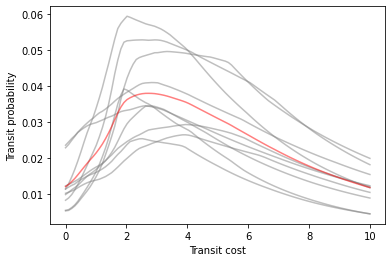

In [ ]:
loss, reg, list_prob = train_DNN('', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

## $\ell_p$ penalties
$$R(\mathbf{w})=\left\|\mathbf{w}\right\|_p=\left(\sum_j w_j^p\right)^{1/p}$$

### $\ell_1$ penalty for parameters

Epoch 1:	 test_accuracy = 76.09%,    avg_test_loss = 0.9106
Epoch 2:	 test_accuracy = 76.06%,    avg_test_loss = 0.7658
Epoch 3:	 test_accuracy = 76.33%,    avg_test_loss = 0.7290
Epoch 4:	 test_accuracy = 76.82%,    avg_test_loss = 0.7216
Epoch 5:	 test_accuracy = 78.20%,    avg_test_loss = 0.6903
Epoch 6:	 test_accuracy = 78.44%,    avg_test_loss = 0.6695
Epoch 7:	 test_accuracy = 78.82%,    avg_test_loss = 0.6578
Epoch 8:	 test_accuracy = 78.67%,    avg_test_loss = 0.6536
Epoch 9:	 test_accuracy = 78.76%,    avg_test_loss = 0.6491
Epoch 10:	 test_accuracy = 78.93%,    avg_test_loss = 0.6453
Done!


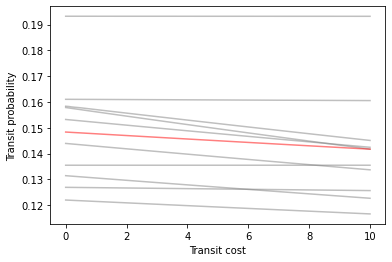

In [ ]:
loss, reg, list_prob = train_DNN('L1', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

### $\ell_2$ penalty for parameters

Epoch 1:	 test_accuracy = 79.02%,    avg_test_loss = 0.5919
Epoch 2:	 test_accuracy = 78.85%,    avg_test_loss = 0.5978
Epoch 3:	 test_accuracy = 79.37%,    avg_test_loss = 0.5800
Epoch 4:	 test_accuracy = 78.99%,    avg_test_loss = 0.5801
Epoch 5:	 test_accuracy = 79.26%,    avg_test_loss = 0.5793
Epoch 6:	 test_accuracy = 79.23%,    avg_test_loss = 0.5708
Epoch 7:	 test_accuracy = 79.43%,    avg_test_loss = 0.5692
Epoch 8:	 test_accuracy = 79.29%,    avg_test_loss = 0.5676
Epoch 9:	 test_accuracy = 78.73%,    avg_test_loss = 0.5782
Epoch 10:	 test_accuracy = 79.37%,    avg_test_loss = 0.5712
Done!


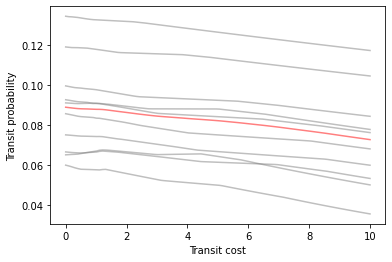

In [ ]:
loss, reg, list_prob = train_DNN('L2', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

## Gradient regularization

### Double backpropagation
Using the gradient w.r.t. input features:
$$R(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)=\sum_{n=1}^N\left\|\nabla_{\mathbf{x}}H(\mathbf{y}_n,P_k(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h))\right\|_2^2$$

Epoch 1:	 test_accuracy = 78.82%,    avg_test_loss = 0.6030
Epoch 2:	 test_accuracy = 78.73%,    avg_test_loss = 0.5965
Epoch 3:	 test_accuracy = 79.11%,    avg_test_loss = 0.5719
Epoch 4:	 test_accuracy = 79.02%,    avg_test_loss = 0.5752
Epoch 5:	 test_accuracy = 79.46%,    avg_test_loss = 0.5629
Epoch 6:	 test_accuracy = 79.78%,    avg_test_loss = 0.5617
Epoch 7:	 test_accuracy = 79.72%,    avg_test_loss = 0.5489
Epoch 8:	 test_accuracy = 79.70%,    avg_test_loss = 0.5731
Epoch 9:	 test_accuracy = 79.43%,    avg_test_loss = 0.5449
Epoch 10:	 test_accuracy = 79.67%,    avg_test_loss = 0.5426
Done!


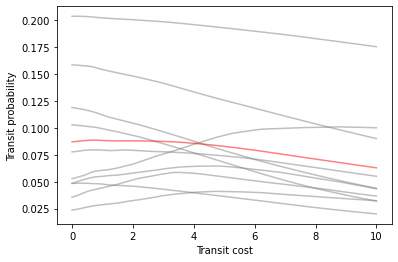

In [ ]:
loss, reg, list_prob = train_DNN('DblBack', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

### Jacobian Regularizer
Using the Jacobian matrix of choice probabilities w.r.t. input features:
$$R(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)=\sum_{n=1}^N\left\|J_P(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)\right\|_F^2$$
Note: Computing Jacobian matrix is time-consuming.

Epoch 1:	 test_accuracy = 78.99%,    avg_test_loss = 0.5868
Epoch 2:	 test_accuracy = 79.26%,    avg_test_loss = 0.5810
Epoch 3:	 test_accuracy = 79.78%,    avg_test_loss = 0.5629
Epoch 4:	 test_accuracy = 79.64%,    avg_test_loss = 0.5683
Epoch 5:	 test_accuracy = 77.70%,    avg_test_loss = 0.6078
Epoch 6:	 test_accuracy = 79.23%,    avg_test_loss = 0.5606
Epoch 7:	 test_accuracy = 79.72%,    avg_test_loss = 0.5745
Epoch 8:	 test_accuracy = 79.46%,    avg_test_loss = 0.5517
Epoch 9:	 test_accuracy = 79.67%,    avg_test_loss = 0.5623
Epoch 10:	 test_accuracy = 79.70%,    avg_test_loss = 0.5509
Done!


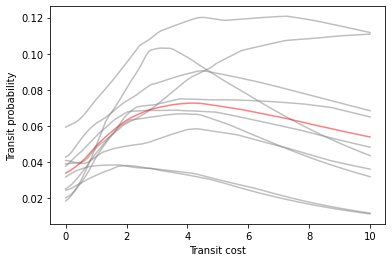

In [ ]:
loss, reg, list_prob = train_DNN('JacReg', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

### Frobenius Regularizer
Using the Jacobian matrix of systematic utilities w.r.t. input features:
$$R(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)=\sum_{n=1}^N\left\|J_V(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)\right\|_F^2$$
Note: Computing the Jacobian matrix is time-consuming.

Epoch 1:	 test_accuracy = 79.31%,    avg_test_loss = 0.5936
Epoch 2:	 test_accuracy = 79.46%,    avg_test_loss = 0.5875
Epoch 3:	 test_accuracy = 79.02%,    avg_test_loss = 0.5922
Epoch 4:	 test_accuracy = 79.70%,    avg_test_loss = 0.6009
Epoch 5:	 test_accuracy = 79.20%,    avg_test_loss = 0.5831
Epoch 6:	 test_accuracy = 79.43%,    avg_test_loss = 0.5861
Epoch 7:	 test_accuracy = 79.26%,    avg_test_loss = 0.5871
Epoch 8:	 test_accuracy = 79.08%,    avg_test_loss = 0.5820
Epoch 9:	 test_accuracy = 79.67%,    avg_test_loss = 0.5828
Epoch 10:	 test_accuracy = 78.58%,    avg_test_loss = 0.5847
Done!


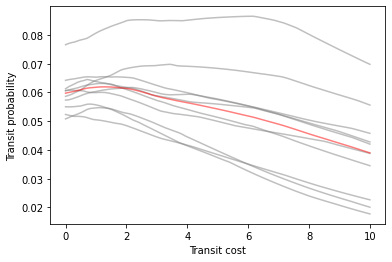

In [ ]:
loss, reg, list_prob = train_DNN('FrobReg', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

### Spectral Regularizer
Using the Jacobian matrix of systematic utilities w.r.t. input features:
$$R(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)=\sum_{n=1}^N\left\|J_V(\mathbf{x}_n;\mathbf{w},\mathbf{w}_h)^\top\mathbf{r}\right\|_2^2$$
where $\mathbf{r}\sim\mathcal{N}(\mathbf{0},I)$.
Note: Computing Jacobian matrix is time-consuming.

Epoch 1:	 test_accuracy = 79.20%,    avg_test_loss = 0.5905
Epoch 2:	 test_accuracy = 79.55%,    avg_test_loss = 0.5842
Epoch 3:	 test_accuracy = 79.11%,    avg_test_loss = 0.5816
Epoch 4:	 test_accuracy = 79.29%,    avg_test_loss = 0.5789
Epoch 5:	 test_accuracy = 79.02%,    avg_test_loss = 0.5791
Epoch 6:	 test_accuracy = 78.67%,    avg_test_loss = 0.5947
Epoch 7:	 test_accuracy = 79.64%,    avg_test_loss = 0.5846
Epoch 8:	 test_accuracy = 79.70%,    avg_test_loss = 0.5774
Epoch 9:	 test_accuracy = 79.23%,    avg_test_loss = 0.5827
Epoch 10:	 test_accuracy = 79.64%,    avg_test_loss = 0.5794
Done!


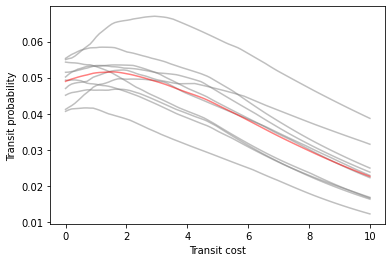

In [ ]:
loss, reg, list_prob = train_DNN('SpecReg', 1e-3)
# Plot individual predictions
for prob in list_prob:
    plt.plot(X_prob['cost_transit'], prob, color='gray', alpha=.5)
# Plot average predictions
avg_prob = np.mean(list_prob, axis=0)
plt.plot(X_prob['cost_transit'], avg_prob, color='red', alpha=.5)
plt.xlabel('Transit cost')
plt.ylabel('Transit probability')
plt.show()

In [ ]:
# plt.plot(loss, label=reg)
# plt.grid(ls='--')
# plt.xticks(np.arange(0, num_epochs, 5), np.arange(1, num_epochs+1, 5))
# plt.xlabel('Number of iterations')
# plt.ylabel('Average Test Loss')
# plt.legend()
# plt.show()